<a href="https://colab.research.google.com/github/jvataidee/pdi_python/blob/main/classificao_orientada_objeto.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Classificação Orientada a Objetos


In [ ]:
!pip install spectral
!pip install rasterio

In [34]:
#Importar bibliotecas
import numpy as np
import cv2
import tifffile as tif
import matplotlib.pyplot as plt
from skimage.transform import rescale
from skimage import exposure
from skimage.segmentation import mark_boundaries, felzenszwalb, slic, quickshift
from spectral import imshow
import rasterio as rio

In [7]:
# Função para redimensionar imagens
def resample(source, target, scale):
    # Redimensionar a imagem de origem para a escala desejada usando a função rescale
    scaled = rescale(source, (scale, scale))

    # Verificar se a altura do alvo é menor que a altura da imagem redimensionada
    if target.shape[0] < scaled.shape[0]:
        # Se for menor, cortar a imagem redimensionada para ter a mesma altura que o alvo
        scaled = scaled[:target.shape[0], :]
    else:
        # Se for maior, cortar o alvo para ter a mesma altura que a imagem redimensionada
        target = target[:scaled.shape[0], :]

    # Verificar se a largura do alvo é menor que a largura da imagem redimensionada
    if target.shape[1] < scaled.shape[1]:
        # Se for menor, cortar a imagem redimensionada para ter a mesma largura que o alvo
        scaled = scaled[:, :target.shape[1]]
    else:
        # Se for maior, cortar o alvo para ter a mesma largura que a imagem redimensionada
        target = target[:, :scaled.shape[1]]

    # Retornar a imagem redimensionada
    return scaled

In [11]:
def expansao(img, percent_min=2, percent_max=98):
    # Cria uma matriz de zeros com o mesmo formato da imagem de entrada
    img2 = np.zeros_like(img)

    # Define os valores mínimo e máximo para expansão
    x, y = 0, 255

    # Calcula os percentis mínimo e máximo da imagem
    pmin = np.percentile(img, percent_min)
    pmax = np.percentile(img, percent_max)

    # Realiza a expansão linear da imagem utilizando os valores mínimo e máximo
    f = x + (img - pmin) * (y - x) / (pmax - pmin)

    # Limita os valores resultantes aos limites mínimo e máximo
    f[f < x] = x
    f[f > y] = y

    # Atribui os valores resultantes à imagem de saída
    img2 = f

    # Retorna a imagem de saída
    return img2

In [94]:
# Lendo arquivos
img = tif.imread('/content/drive/MyDrive/pdi_python/21 - PDI com Python/03 - Classificações Temáticas/CUBO_GEOBIA.tif')
vv = tif.imread('/content/drive/MyDrive/pdi_python/21 - PDI com Python/03 - Classificações Temáticas/S1A_VV.tif')
vh = tif.imread('/content/drive/MyDrive/pdi_python/21 - PDI com Python/03 - Classificações Temáticas/S1A_VH.tif')

## Empilhados dados

In [66]:
# Reamostrando imagens
vv_20 = resample(vv, img[:,:,0], 0.6)
vh_20 = resample(vh, img[:,:,0], 0.6)

In [10]:
stack = np.dstack([img, vv_20, vh_20])

In [23]:
stack.shape

(1570, 2296, 16)

/usr/local/lib/python3.10/dist-packages/spectral/graphics/spypylab.py:796: UserWarning: Failed to create RectangleSelector object. Interactive pixel class labeling will be unavailable.
  warnings.warn(msg)


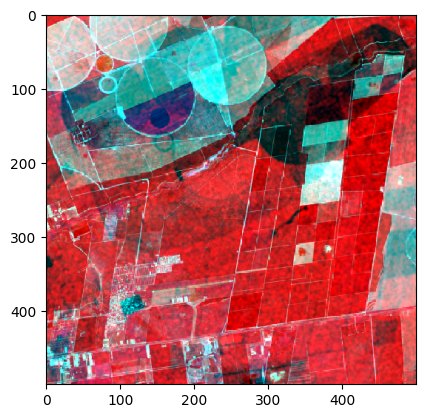

In [24]:
imshow(stack[500:1000,500:1000,], (15,0,1), stretch = (0.02,0.98));

## Expansão Histograma

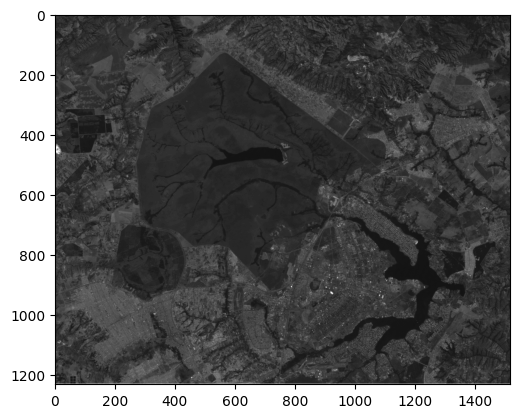

In [27]:
#Leitura d imagem
b3 = tif.imread('/content/drive/MyDrive/pdi_python/21 - PDI com Python/01 - Pré-Processamento/imagens/L71221071_07120010720_DN_B3.tif')
imshow(b3);

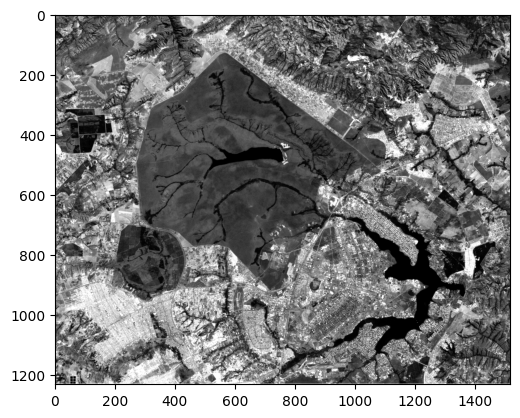

In [29]:
#Cálculo da expansão e visualização
s = expansao(b3, 2, 98)
imshow(s);

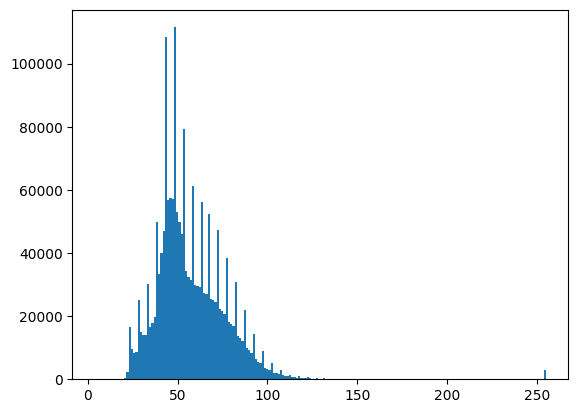

In [31]:
b3_flat = b3.flatten()
plt.hist(b3_flat, bins=200)
plt.show()

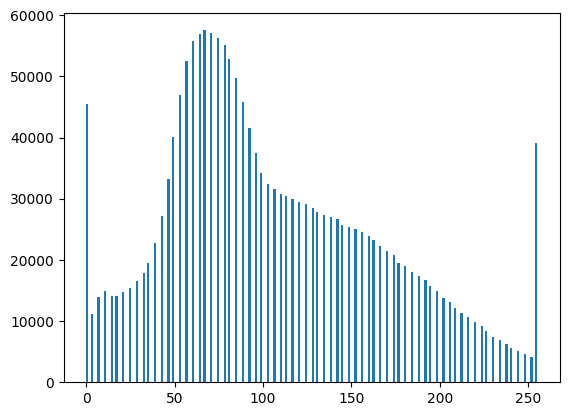

In [32]:
s_flat = s.flatten()
plt.hist(s_flat, bins=200)
plt.show()

## Segmentando imagens

In [51]:
# Lendo imagem como array
src = rio.open('/content/drive/MyDrive/pdi_python/21 - PDI com Python/03 - Classificações Temáticas/cubo_s2.tif')

In [36]:
list_band = [src.read(i+1) for i in range(src.count)]
img = np.dstack(list_band)

# Armazenando metadados da imagem original
meta = src.profile
meta

{'driver': 'GTiff', 'dtype': 'float32', 'nodata': None, 'width': 2296, 'height': 1570, 'count': 9, 'crs': CRS.from_epsg(32723), 'transform': Affine(18.823529398954705, 0.0, 409412.9972,
       0.0, -18.823529426751147, 8682127.6725), 'blockysize': 1, 'tiled': False, 'interleave': 'pixel'}

In [37]:
img.shape

(1570, 2296, 9)

### Segmentadores
- [Quickshift](https://www.researchgate.net/publication/263010647_Automatic_Quick-Shift_Segmentation_for_Color_Images)
- [SLIC](https://ietresearch.onlinelibrary.wiley.com/doi/10.1049/iet-ipr.2019.0255)
- [Felzenszwalb](https://lapix.ufsc.br/ensino/visao/segmentacao-com-grafos-felzenszwalb-and-huttenlocher-method-fh/)


In [38]:
# Reamostrando para valores entre -1 e 1
img2 = exposure.rescale_intensity(img)

# Segmentadores

# Quickshift
quick = quickshift(img2[:, :, :3].astype('double'), kernel_size=5, max_dist=1000, ratio=0.1)

# SLIC
slic_ = slic(img2, n_segments=5000, compactness=0.1, sigma=1, start_label=1)

# Felzenszwalb
felzen = felzenszwalb(img2, scale=1, sigma=1, min_size=70)

/usr/local/lib/python3.10/dist-packages/skimage/_shared/utils.py:394: RuntimeWarning: Got image with third dimension of 9. This image will be interpreted as a multichannel 2d image, which may not be intended.
  return func(*args, **kwargs)


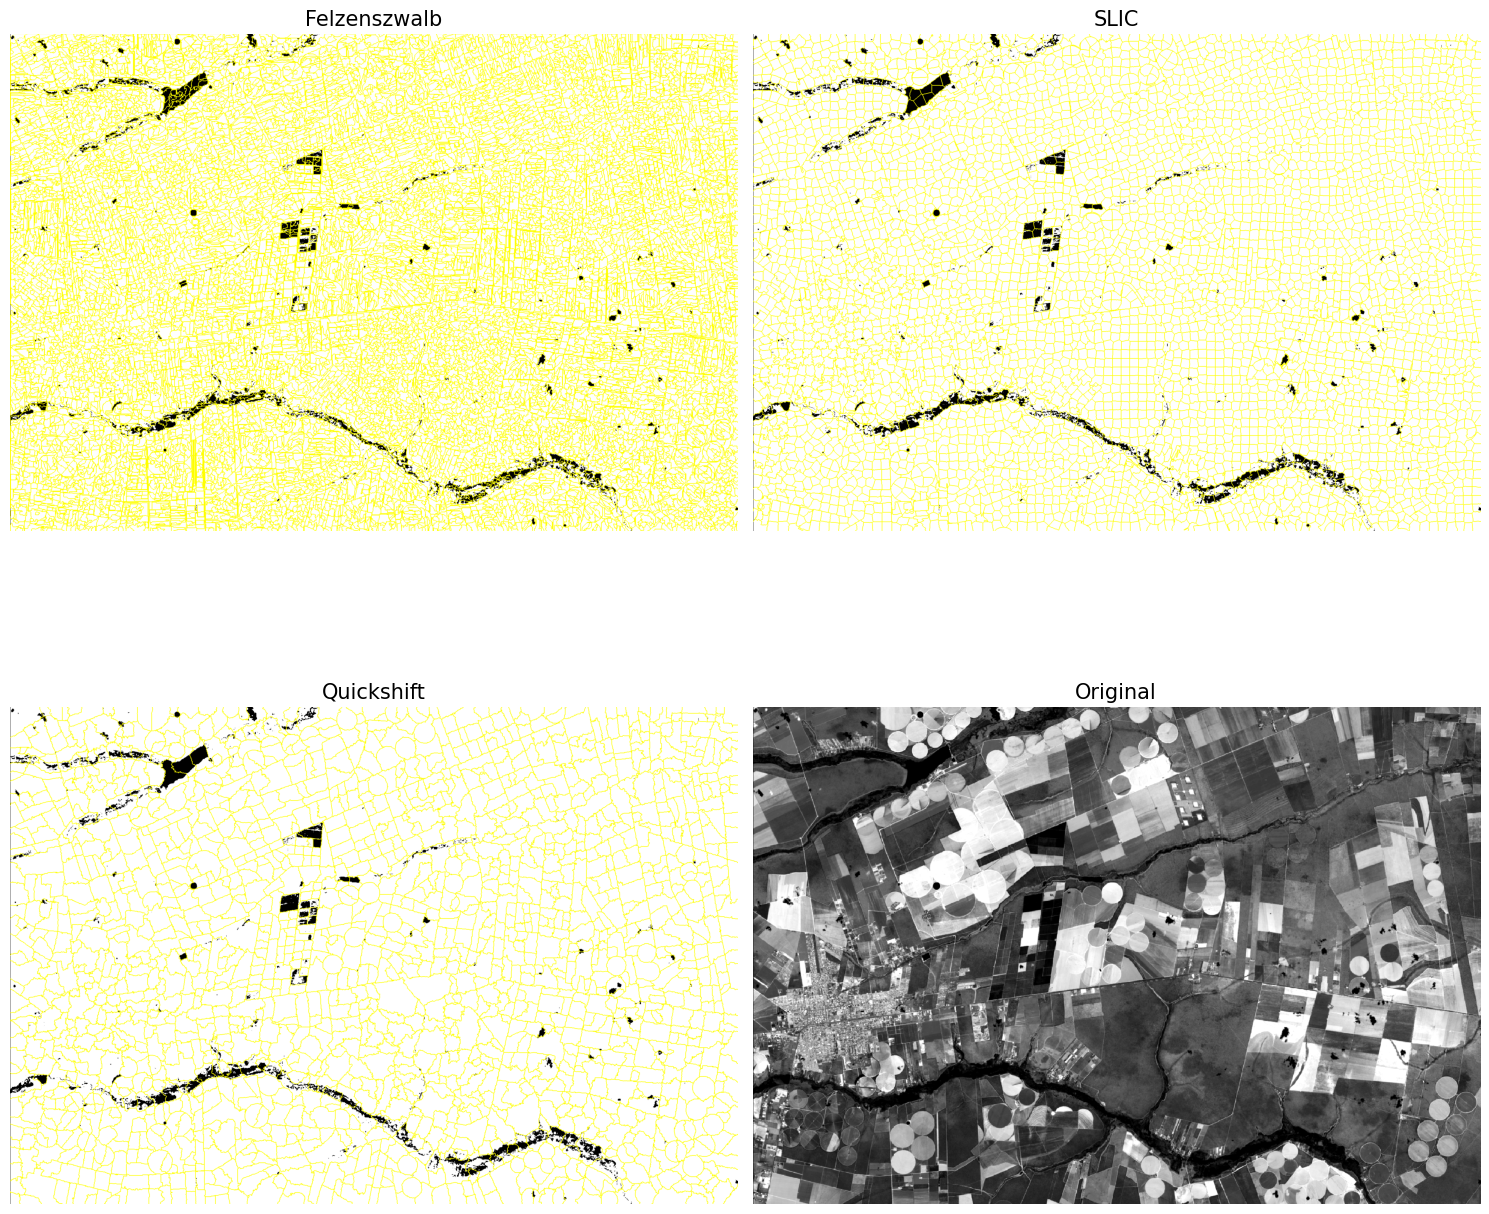

In [119]:
fig, ax = plt.subplots(2, 2, figsize=(15, 15), sharex=True, sharey=True)

ax[0, 0].imshow(mark_boundaries(expansao(img2[:,:,7]), felzen),  cmap='Spectral_r')
ax[0, 0].set_title("Felzenszwalb", fontsize=15)
ax[0, 1].imshow(mark_boundaries(expansao(img2[:,:,7]), slic_),  cmap='Spectral')
ax[0, 1].set_title('SLIC', fontsize=15)
ax[1, 0].imshow(mark_boundaries(expansao(img2[:,:,7]), quick),  cmap='Spectral')
ax[1, 0].set_title('Quickshift', fontsize=15)
ax[1, 1].imshow(expansao(img2[:,:,7]), cmap="gray")
ax[1, 1].set_title('Original', fontsize=15)

for a in ax.ravel():
    a.set_axis_off()
plt.tight_layout()
plt.show()

## Criando planos de informação

In [104]:
with rio.open('/content/drive/MyDrive/pdi_python/21 - PDI com Python/01 - Pré-Processamento/L71221071_07120010720_DN.tif') as src:
  b1 = src.read(1)
  b2 = src.read(2)
  b3 = src.read(3)
  b4 = src.read(4)
  b5 = src.read(5)
  b7 = src.read(6)

In [110]:
# Criando planos de informação
# Cálculo do NDVI (Índice de Vegetação por Diferença Normalizada)
ndvi = (b4 - b3) / (b4 + b3)

# Aplicação do filtro de Sobel na direção x
sobelx = cv2.Sobel(src=ndvi, ddepth=-1, dx=1, dy=0, ksize=5)

# Aplicação do filtro de Sobel na direção y
sobely = cv2.Sobel(src=ndvi, ddepth=-1, dx=0, dy=1, ksize=5)

<ipython-input-110-e18dfbc51e95>:3: RuntimeWarning: divide by zero encountered in true_divide
  ndvi = (b4 - b3) / (b4 + b3)


In [116]:
# Reamostragem dos planos VV e VH
vv_20 = resample(vv, ndvi, 0.6)
vh_20 = resample(vh, ndvi, 0.6)

# Cálculo da razão VV/VH
razao = vv / vh
razao_20 = resample(razao, ndvi, 0.6)

In [117]:
# Empilhando planos de informação
stack_features = np.dstack([ndvi, sobelx, sobely, vv_20, vh_20, razao_20])

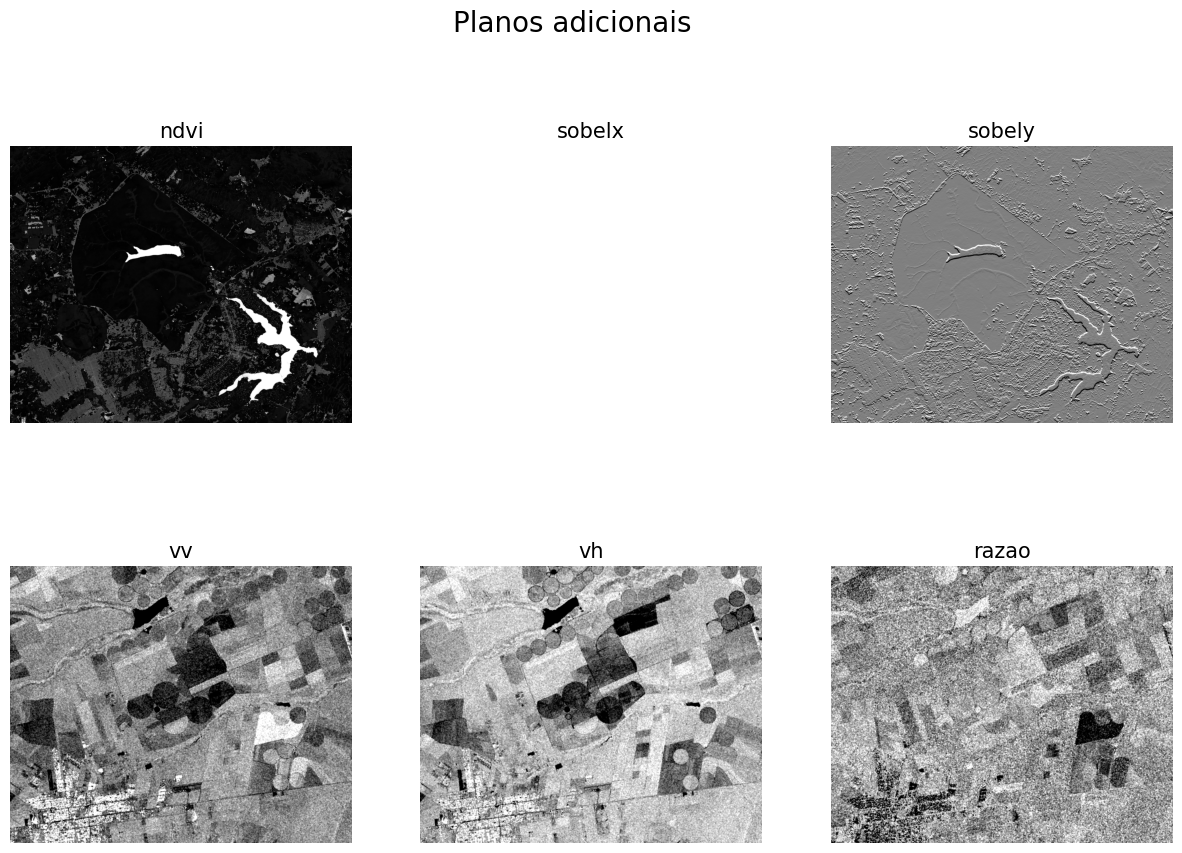

In [118]:
lista_nomes= ['ndvi', 'sobelx', 'sobely', 'vv', 'vh', 'razao']

#Plotando em um gráfico de duas linhas e três colunas
fig,axes = plt.subplots(2,3, figsize=(15,10),sharex='all',sharey='all')
fig.suptitle('Planos adicionais', fontsize=20)
axes = axes.ravel()

for i in range(stack_features.shape[2]):
    axes[i].imshow(expansao(stack_features[:,:,i]),cmap='gray')
    axes[i].set_title(lista_nomes[i],fontsize=15)
    axes[i].axis('off')